In [16]:
! pip install opencv-python
! pip install ftfy regex tqdm
! pip install streamlit
! pip install torchray

In [17]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
from model import build_model
from clip_ import load, tokenize
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import streamlit as st
from torchray.attribution.grad_cam import grad_cam
from matplotlib import rc
import os
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import matplotlib

In [18]:
def interpret_vit(image, text, model, device, index=None):
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    if index is None:
        index = np.argmax(logits_per_image.cpu().data.numpy(), axis=-1)
    one_hot = np.zeros((1, logits_per_image.size()[-1]), dtype=np.float32)
    one_hot[0, index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()
    one_hot.backward(retain_graph=True)

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    for blk in image_attn_blocks:
        grad = blk.attn_grad
        cam = blk.attn_probs
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.clamp(min=0).mean(dim=0)
        R += torch.matmul(cam, R)
    R[0, 0] = 0
    image_relevance = R[0, 1:]

    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255*vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    #plt.imshow(vis)
    return vis
    #return vis
#     plt.show()

In [19]:
st.sidebar.header('Options')
alpha = st.sidebar.radio("select alpha", [0.5, 0.7, 0.8], index=1)
layer = st.sidebar.selectbox("select saliency layer", ['layer4.2.relu'], index=0)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_rn_4, preprocess = load("RN50x4", device=device, jit=False)
model_rn, preprocess = load("RN50", device=device, jit=False)

print(sum(p.numel() for p in model_rn.parameters() if p.requires_grad))

def interpret_rn(image, text, model, device, index=None):   
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features_norm = image_features.norm(dim=-1, keepdim=True)
    image_features_new = image_features / image_features_norm
    text_features_norm = text_features.norm(dim=-1, keepdim=True)
    text_features_new = text_features / text_features_norm
    
    logit_scale = model.logit_scale.exp()
    logits_per_image = logit_scale * image_features_new @ text_features_new.t()
    probs = logits_per_image.softmax(dim=-1).cpu().detach().numpy().tolist()
    
    text_prediction = (text_features_new * image_features_norm)
    image_relevance = grad_cam(model.visual, image.type(model.dtype), text_prediction, saliency_layer=layer)
        
#     image_relevance = grad_cam(model.visual, image.type(model.dtype), image_features, saliency_layer=layer)

    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    plt.imshow(vis)
    #return vis

102007137


In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = load("ViT-B/32", device=device, jit=False)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

151277313


In [21]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [22]:
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# matplotlib.rcParams['mathtext.size'] = 16

In [23]:
def sim_score(model, image, texts):
        texts = tokenize(texts).to(device)
        logits_per_image, logits_per_text = model(image, texts)
        probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()

        return probs[0]

In [24]:
import pandas as pd



model_types = ["ViT", "RN50"]

font = {
    'size': 15,
}

ori_preprocess = Compose([
        Resize((224), interpolation=Image.BICUBIC),
    CenterCrop(size=(224, 224)),
        ToTensor()])
print(preprocess)

Compose(
    Resize(size=224, interpolation=PIL.Image.BICUBIC)
    CenterCrop(size=(224, 224))
    <function _transform.<locals>.<lambda> at 0x7fd5902435f0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


In [275]:
happy_prc = {"ViT":0 , "RN50":0}
#fig, ax = plt.subplots(len(2*img_ids), 3, figsize=(16,16))
import matplotlib.backends.backend_pdf
#pdf = matplotlib.backends.backend_pdf.PdfPages("happydata_happy_vs_not-happy.pdf")

img_ids = []
texts  = ["this is a happy person", "this is not a happy person"]
happy_root = "/scratch/students/2021-fall-sp-mamooler/CLIP-VIL/human_emotion/input/affectnetsample/class002"
for img in os.listdir(happy_root):
    if img.endswith('.jpg'):
        img_ids.append(img)
        

for id_, img_id in enumerate(img_ids):
    
    for model_id, model_type in enumerate(model_types):
        
        img_path =  os.path.join(happy_root, img_id)
        image = ori_preprocess(Image.open(img_path))
        p_image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

        
        #plt.subplot(subplot+i)
        if model_type=="ViT":
            current_model = model
        elif model_type=="RN50":
            current_model = model_rn
        else:
            current_model = model_rn_4
            
        similarities = sim_score(current_model, p_image, texts)
        if similarities[0] > similarities[1]:
            happy_prc[model_type] += 1
        """
        else:
        #    print(model_type, similarities)
            fig = plt.figure(figsize=(16, 16))
            plt.tight_layout()
            plt.subplot(131)
            plt.imshow(image.permute(1, 2, 0))
            plt.axis('off')
            plt.title(f"{model_type}", **font, y=-0.15)
            
            for i,text in enumerate(texts):
                t_text = tokenize(text).to(device)
                plt.subplot(132+i)
                if model_type=="ViT":
                    interpret_vit(model=current_model, image=p_image, text=t_text, device=device, index=0)
                else:
                    interpret_rn(model=current_model, image=p_image, text=t_text, device=device, index=0)
                plt.axis('off')
                plt.title(f"{text} | {round(float(similarities[i]),4)}", **font,y=-0.15)
                plt.tight_layout()
            pdf.savefig(fig)
        """

for model_type, tp in happy_prc.items():
    happy_prc[model_type] /= len(img_ids)
#pdf.close()
print(happy_prc)

KeyboardInterrupt: 

In [12]:
sad_img_ids = []
texts  = ["this is a sad person", "this is not a sad person"]
sad_root = "/scratch/students/2021-fall-sp-mamooler/CLIP-VIL/human_emotion/input/affectnetsample/class003"
for img in os.listdir(sad_root):
    if img.endswith('.jpg'):
        sad_img_ids.append(img)

In [14]:
sad_prc = {"ViT":0 , "RN50":0}
#fig, ax = plt.subplots(len(2*img_ids), 3, figsize=(16,16))
#pdf = matplotlib.backends.backend_pdf.PdfPages("saddata_sad_vs_not-sad.pdf")
for id_, img_id in enumerate(sad_img_ids):
    
    for model_id, model_type in enumerate(model_types):
        
        img_path =  os.path.join(sad_root, img_id)
        image = ori_preprocess(Image.open(img_path))
        p_image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)


        #plt.subplot(subplot+i)
        if model_type=="ViT":
            current_model = model
        else:
            current_model = model_rn
      
            
        similarities = sim_score(current_model, p_image, texts)
        if similarities[0] > similarities[1]:
            sad_prc[model_type] += 1
        """
        else:
        #    print(model_type, similarities)
            fig = plt.figure(figsize=(16, 16))
            plt.tight_layout()
            plt.subplot(131)
            plt.imshow(image.permute(1, 2, 0))
            plt.axis('off')
            plt.title(f"{model_type}", **font, y=-0.15)
            
            for i,text in enumerate(texts):
                t_text = tokenize(text).to(device)
                plt.subplot(132+i)
                if model_type=="ViT":
                    interpret_vit(model=model, image=p_image, text=t_text, device=device, index=0)
                else:
                    interpret_rn(model=model_rn, image=p_image, text=t_text, device=device, index=0)
                plt.axis('off')
                plt.title(f"{text} | {round(float(similarities[i]),4)}", **font,y=-0.15)
                plt.tight_layout()
    
            pdf.savefig(fig)
        """
        
for model_type, tp in sad_prc.items():
    sad_prc[model_type] /= len(sad_img_ids)

#pdf.close()
print(sad_prc)

{'ViT': 0.162, 'RN50': 0.058}


# Attention Bias

In [25]:
def interpret_vit(image, text, model, device, index=None):
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    if index is None:
        index = np.argmax(logits_per_image.cpu().data.numpy(), axis=-1)
    one_hot = np.zeros((1, logits_per_image.size()[-1]), dtype=np.float32)
    one_hot[0, index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()
    one_hot.backward(retain_graph=True)

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    for blk in image_attn_blocks:
        grad = blk.attn_grad
        cam = blk.attn_probs
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.clamp(min=0).mean(dim=0)
        R += torch.matmul(cam, R)
    R[0, 0] = 0
    image_relevance = R[0, 1:]

  

    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image_relevance = image_relevance / np.max(image_relevance)
    image_relevance = np.uint8(255*image_relevance)
    image_relevance = cv2.cvtColor(np.array(image_relevance), cv2.COLOR_RGB2BGR)

    #plt.imshow(vis)
    return image_relevance
    #return vis
#     plt.show()

In [26]:
def interpret_rn(image, text, model, device, index=None):   
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features_norm = image_features.norm(dim=-1, keepdim=True)
    image_features_new = image_features / image_features_norm
    text_features_norm = text_features.norm(dim=-1, keepdim=True)
    text_features_new = text_features / text_features_norm
    
    logit_scale = model.logit_scale.exp()
    logits_per_image = logit_scale * image_features_new @ text_features_new.t()
    probs = logits_per_image.softmax(dim=-1).cpu().detach().numpy().tolist()
    
    text_prediction = (text_features_new * image_features_norm)
    image_relevance = grad_cam(model.visual, image.type(model.dtype), text_prediction, saliency_layer=layer)
        


    image_relevance = image_relevance.reshape(1, 1, 7, 7)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image_relevance = image_relevance / np.max(image_relevance)
    image_relevance = np.uint8(255*image_relevance)
    image_relevance = cv2.cvtColor(np.array(image_relevance), cv2.COLOR_RGB2BGR)

    return image_relevance

In [27]:
image_ids = []
root = "/scratch/students/2021-fall-sp-mamooler/CLIP-VIL/human_emotion/input/affectnetsample/"
texts  = ["this person is sad", "this person is happy"]
for directory in os.listdir(root):
    for file in os.listdir(root+directory):
        if file.endswith(".jpg"):
            image_ids.append(f"{directory}/{file}")

/home/mamooler/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/mamooler/miniconda/envs/habitat/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


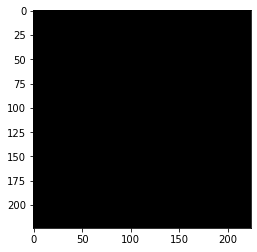

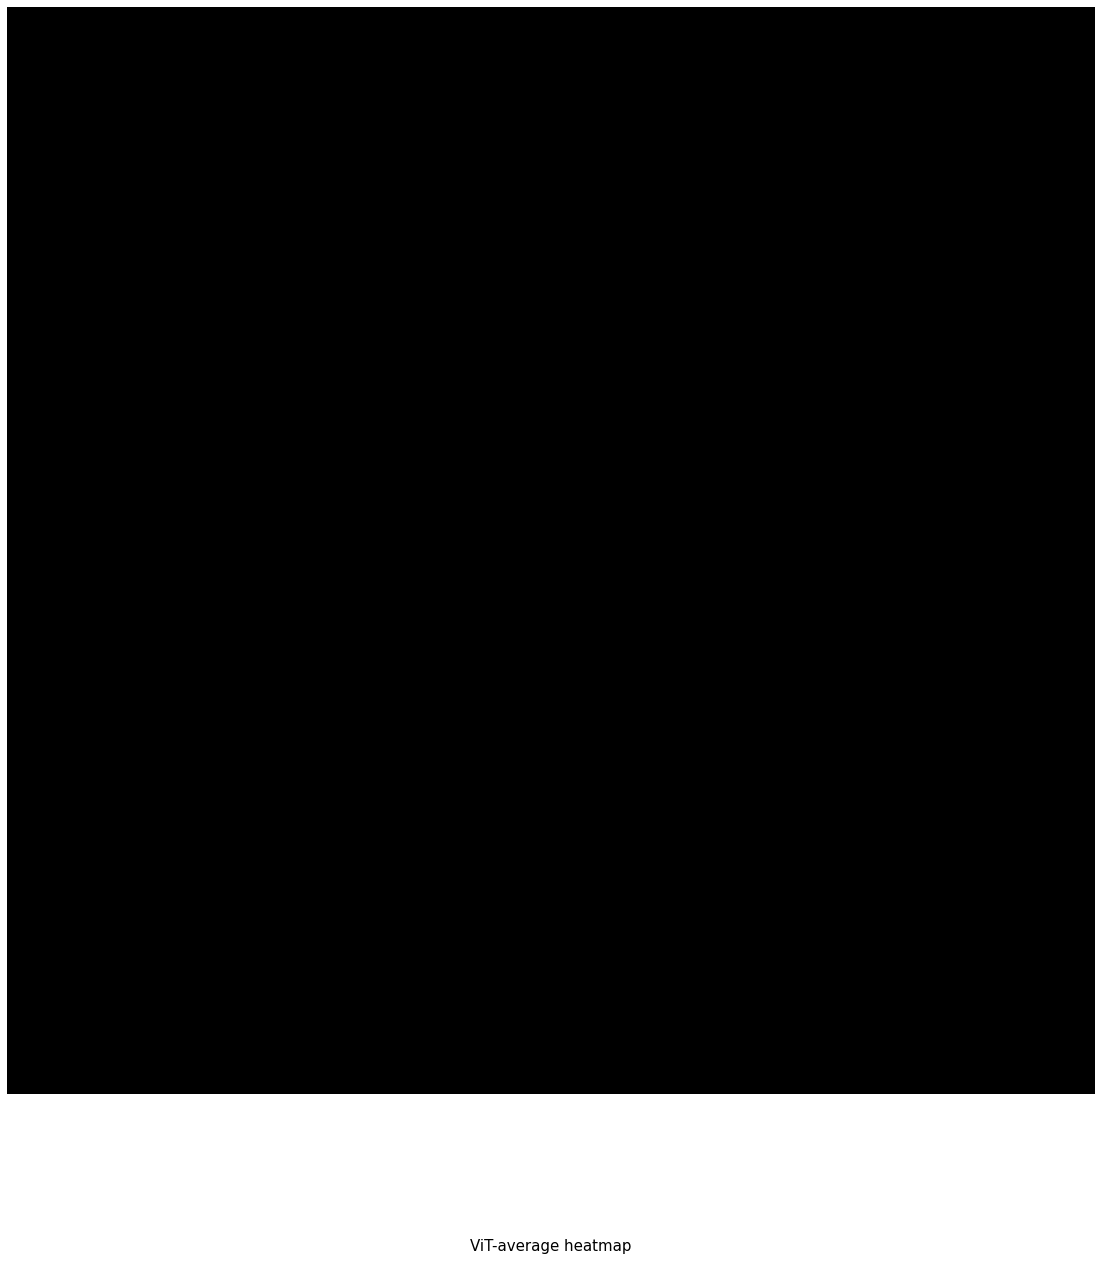

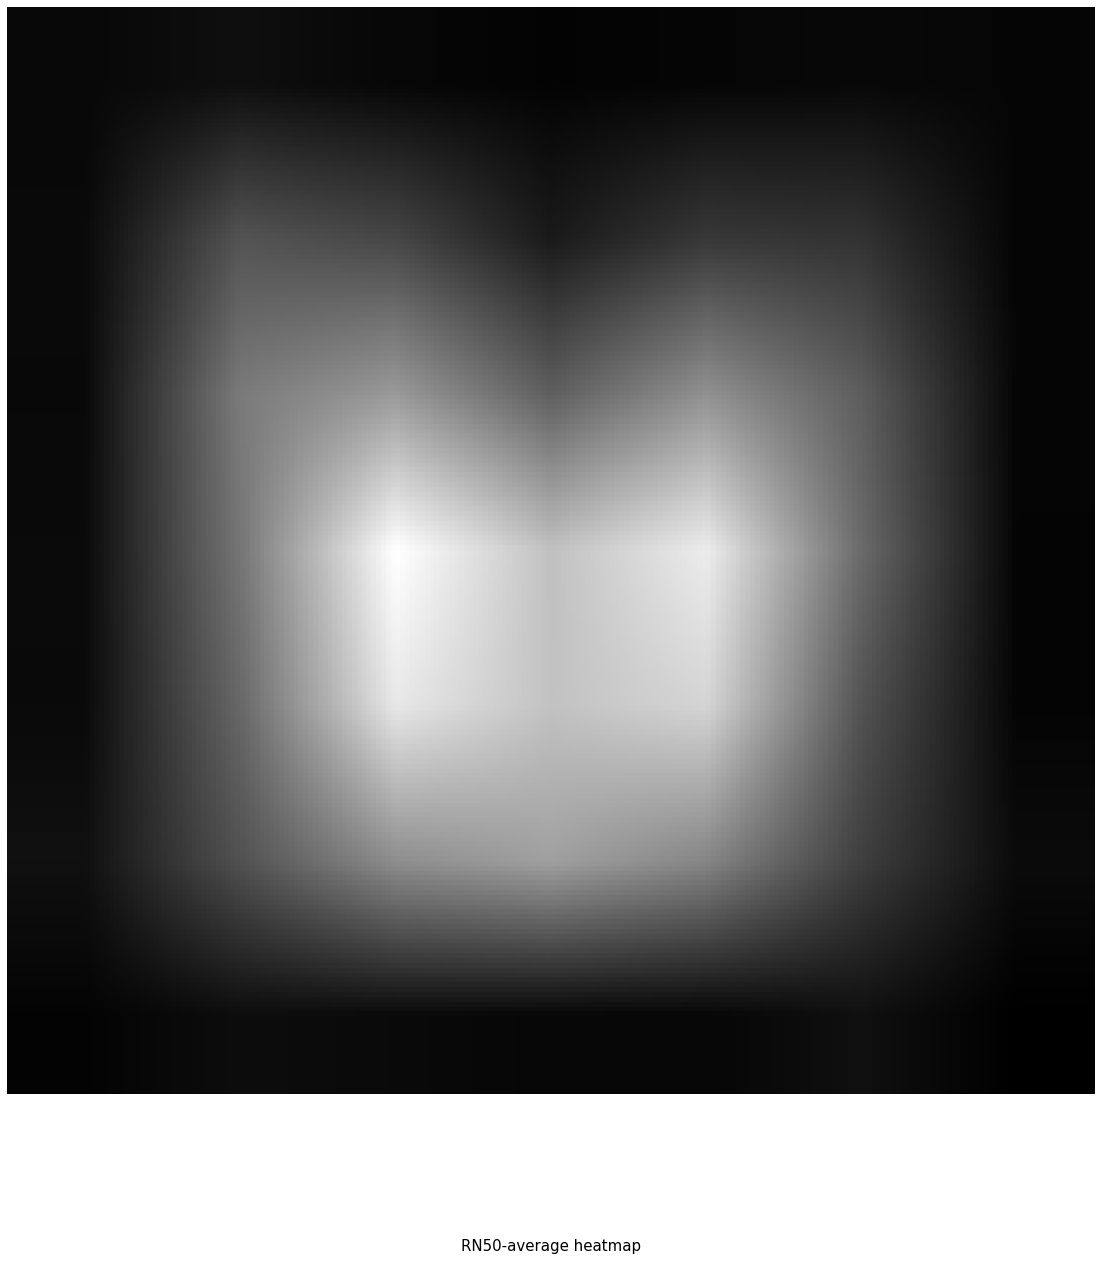

In [28]:
model_types = ["ViT", "RN50"]

for model_type in model_types:
    vis = np.zeros(p_image[0].permute(1, 2, 0).size())
    plt.imshow(vis)
    for id_, img_id in enumerate(image_ids):

            img_path =  os.path.join(root, img_id)
            image = ori_preprocess(Image.open(img_path))
            p_image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

            for i,text in enumerate(texts):
                t_text = tokenize(text).to(device)
                if model_type=="ViT":
                    vis += interpret_vit(model=model, image=p_image, text=t_text, device=device, index=0)/len(image_ids)
                else:
                    vis += interpret_rn(model=model_rn, image=p_image, text=t_text, device=device, index=0)/len(image_ids)
    vis = vis/np.max(vis)
    plt.figure(figsize=(20, 20))
    plt.imshow(vis)
    plt.axis('off')
    plt.title(f"{model_type}-average heatmap", **font, y=-0.15)
    plt.savefig(f'{model_type}attention_bias_affectnet.jpg', bbox_inches='tight')

In [262]:
import math

In [265]:
def margin_of_error(p, n):
    return 2*math.sqrt((p*(1-p))/n)

for p in [0.952, 0.788, 0.01, 0.044, 0.162, 0.058]:
    print(margin_of_error(p, 500))

0.01911983263525077
0.036557461618662745
0.008899438184514795
0.018344263408488222
0.032955242375075924
0.020906649659857026
